In [2]:
from mgmt.data.nifti import load_subjects
from mgmt.visualize.subject import plot_subject_with_label, plot_volume

import torchio as tio
from mgmt.transforms.rescale_intensity import RescaleIntensity
from mgmt.data.subject_transforms import CropLargestTumor

from mgmt.transforms.skull_crop import SkullCropTransform

import torch

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

from torchio.transforms.preprocessing.spatial.to_canonical import ToCanonical
import pickle

2023-08-10 07:34:05.876150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 07:34:06.546229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
subjects = load_subjects(
    "/home/bryan/data/brain_tumor/caidm_3d_240",
    "/home/bryan/data/brain_tumor/classification/train_labels.csv",
    modality=["fla", "t1w", "t1c", "t2w"]
)

In [4]:
for subject in subjects:
    if subject.patient_id_str == "MGMT-006878":
        break

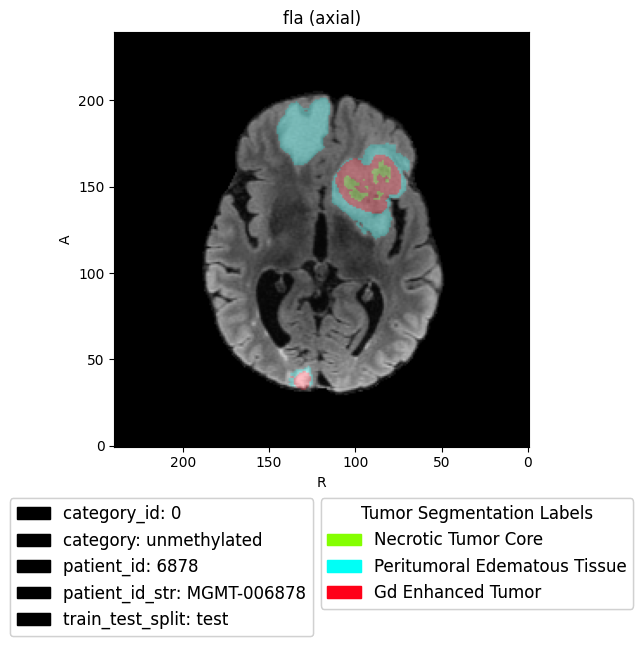

In [5]:
plot_subject_with_label(subject, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [6]:
subject.fla.shape

(1, 240, 240, 155)

In [7]:
sampler = tio.data.LabelSampler(
    patch_size=96,
)

In [8]:
generator = sampler(subject)
patch = next(generator)

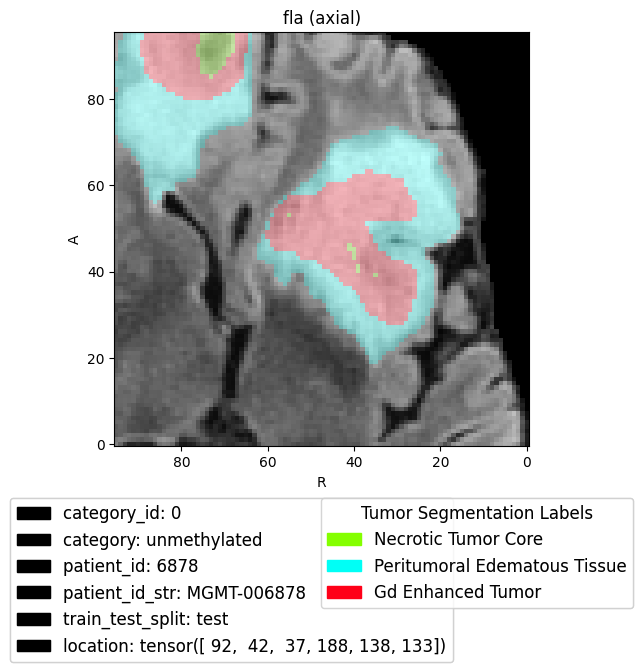

In [9]:
plot_subject_with_label(patch, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

# location: [X_ini, Y_ini, Z_ini, X_fin, Y_fin, Z_fin] where ini is start index, fin is end index of crop range

In [10]:
sampler = tio.data.WeightedSampler(
    patch_size=96,
    probability_map="tumor"
)
generator = sampler(subject)
patch = next(generator)

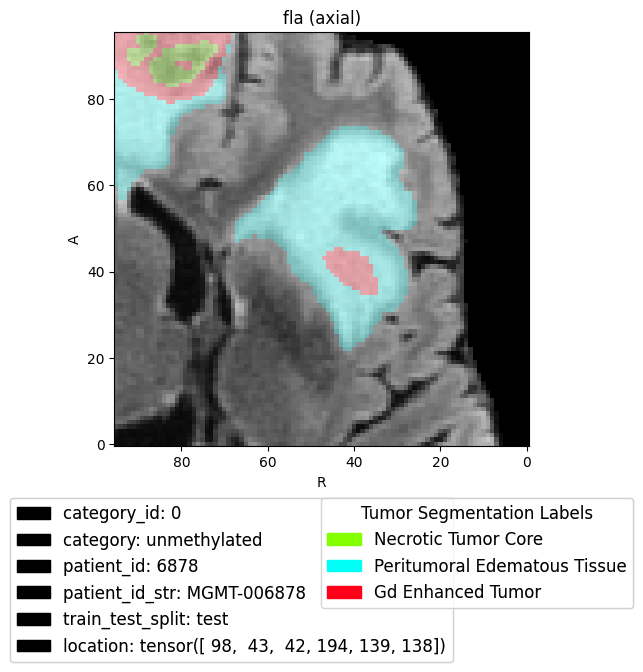

In [11]:
plot_subject_with_label(patch, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [12]:
subject = ToCanonical()(subject)
subject_crop = SkullCropTransform(mask_image_name="fla")(subject)

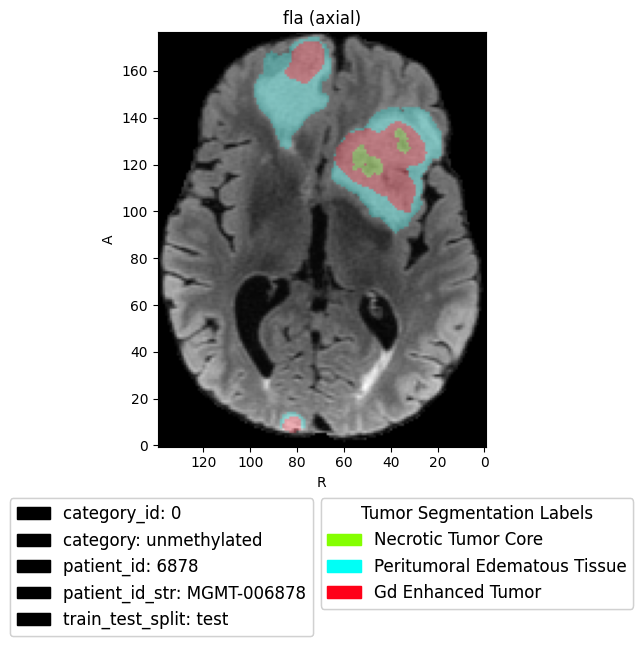

In [13]:
plot_subject_with_label(subject_crop, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

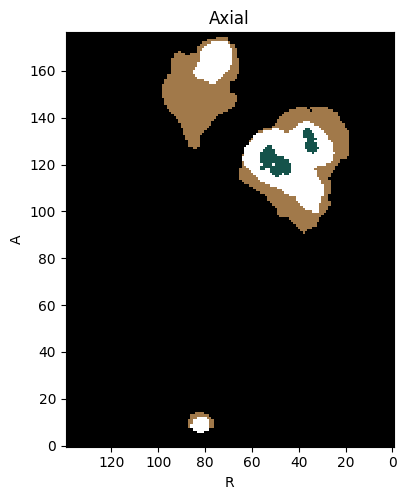

In [14]:
plot_volume(subject_crop.tumor, single_axis="axial");

In [15]:
def segmentation_to_probability_map(tumor, patch_size=64, device=torch.device("cuda")):
    pz = patch_size
    binary = (tumor > 0).type(torch.float32)
    weight = torch.ones([1,1,pz,pz,pz], dtype=torch.float32, device=device)
    tumor_device = binary[None,...].to(device=device)
    conv = torch.nn.functional.conv3d(
        tumor_device,
        weight,
        bias=None,
    )
    log = torch.log(conv)
    log[log < 0] = 0.0
    padded = torch.nn.functional.pad(
        log[0], 
        [pz//2, pz//2-1, pz//2, pz//2-1,pz//2, pz//2-1, 0, 0]
    )
    return padded.cpu()

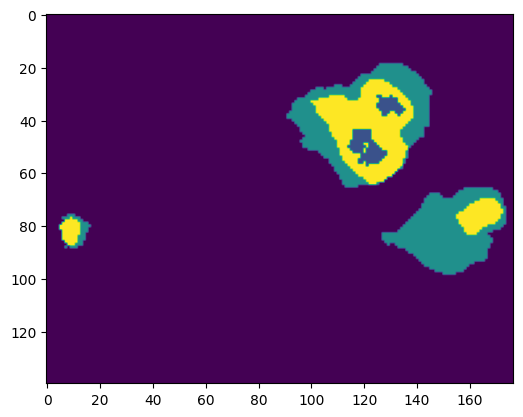

In [16]:
plt.imshow(subject_crop.tumor.data[0,...,70])

In [17]:
prob_map = segmentation_to_probability_map(subject_crop.tumor.data)

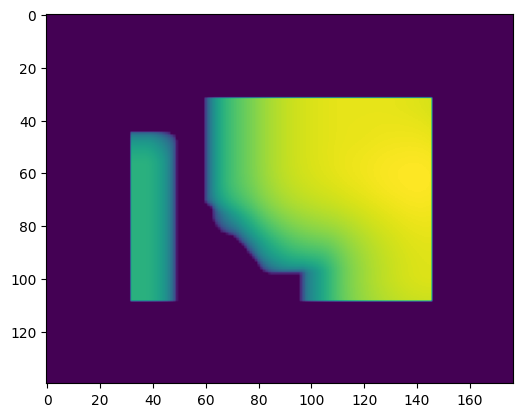

In [18]:
plt.imshow(prob_map[0,...,70])

In [20]:
prob_map.shape

torch.Size([1, 140, 177, 143])

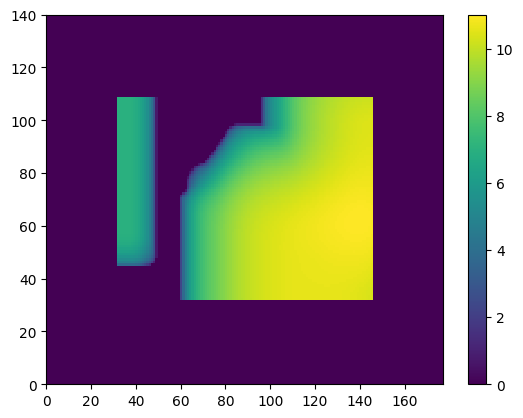

In [19]:
heatmap = plt.pcolor(prob_map[0,...,70])
plt.colorbar(heatmap)

In [116]:
subject_crop.add_image(
    tio.LabelMap(tensor=prob_map, affine=subject_crop.tumor.affine),
    image_name="probability_map",
)

In [136]:
sampler = tio.data.WeightedSampler(
    patch_size=[100, 50, 25],
    probability_map="probability_map"
)
generator = sampler(subject_crop)
patch = next(generator)

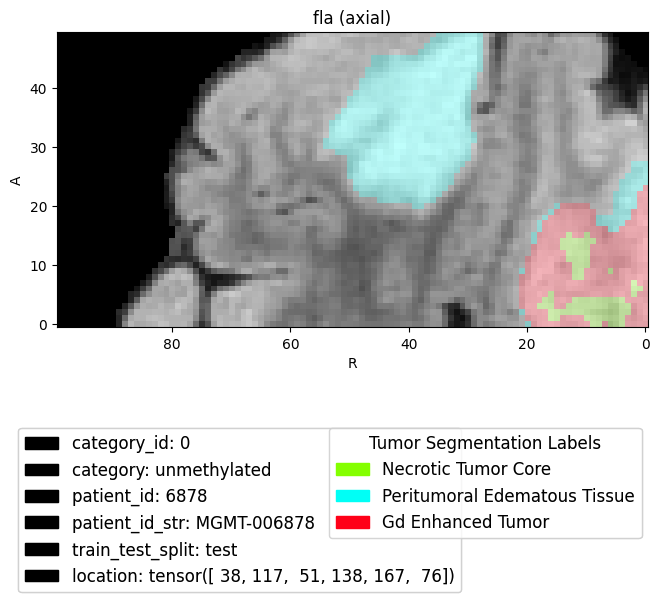

In [137]:
plot_subject_with_label(patch, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

In [139]:
patch.fla.shape

(1, 100, 50, 25)

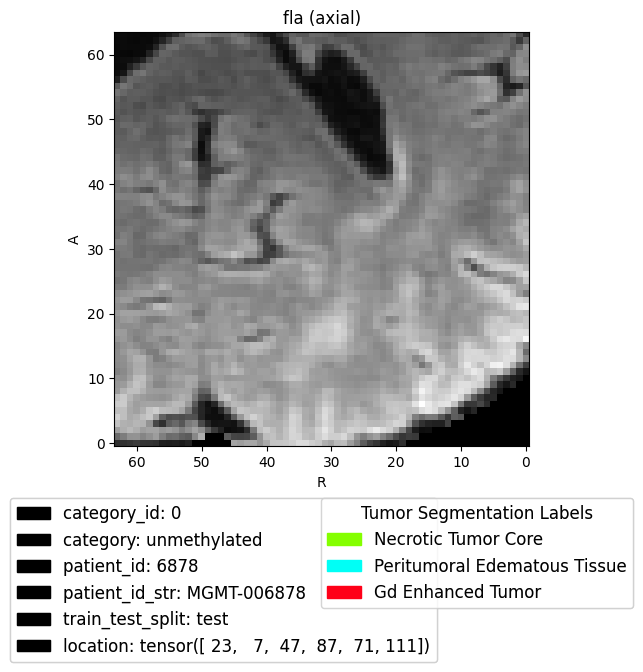

In [120]:
patch = next(generator)
plot_subject_with_label(patch, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"]);

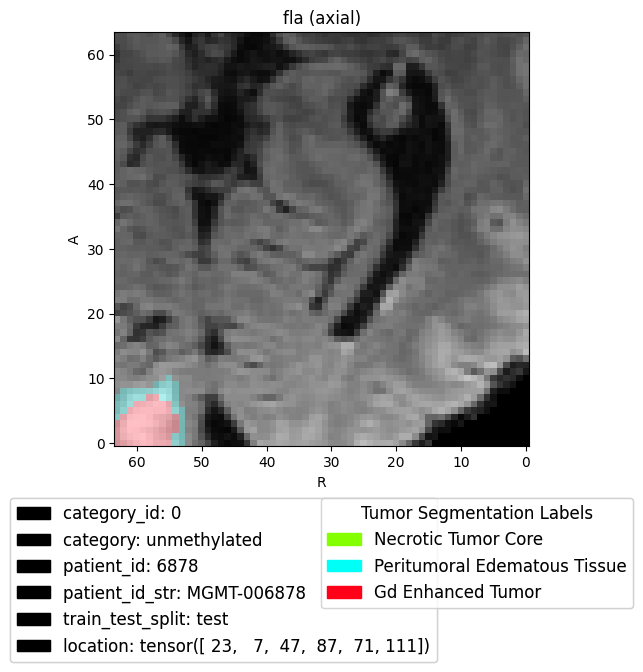

In [125]:
plot_subject_with_label(patch, show=True, add_metadata=True, add_tumor_legend=True, single_axis="axial", subject_include=["fla"], indices=(32, 32, 20));

In [130]:
with open("/home/bryan/Downloads/2023-08-06/subject_crop.pkl", "wb") as f:
    pickle.dump(subject_crop, f)

In [131]:
with open("/home/bryan/Downloads/2023-08-06/subject_crop.pkl", "rb") as f:
    loaded_subject = pickle.load(f)

In [134]:
import time

class Timer:
    def __init__(self):
        self.start_time = None
        self.total_time = 0
        self.count = 0

    def start(self):
        if self.start_time is not None:
            raise Exception("Timer is already running")
        self.start_time = time.time()

    def stop(self):
        if self.start_time is None:
            raise Exception("Timer is not running")
        elapsed_time = time.time() - self.start_time
        self.total_time += elapsed_time
        self.count += 1
        self.start_time = None

    def average(self):
        if self.count == 0:
            return 0
        return self.total_time / self.count

In [135]:
timer = Timer()
for _ in range(500):
    timer.start()
    with open("/home/bryan/Downloads/2023-08-06/subject_crop.pkl", "rb") as f:
        loaded_subject = pickle.load(f)
    timer.stop()
print(timer.average()*1000)

22.819621086120605
